### Reductions and Strong Scaling

Reduction is the process of applying an operator to all elements in a vector/matrix typically to output a scalar.  Wikipedia says, 'Reduce is a collective communication primitive used in the context of a parallel programming model to combine multiple vectors into one, using an associative binary operator $\oplus$.  It is easiest to envision this operation on a tree with addition

![this](https://upload.wikimedia.org/wikipedia/commons/e/ee/Binomial_tree.gif)

The most common way to execute a reduction is a tree-hierarchy of blocks (chunks) of elements.
  1. reduce each chunk to a scalar
  2. build new chunks of scalars ouput from step 1. 
  3. repeat
There are more complex approaches that involve pipelining results that might be faster on some architectures. Not important.

Dask and other frameworks do this implicitly when calling aggregation functions, <code>mean, min, max, sum</code> and explicitly with a user defined function <code>dask.bag.fold()</code> and <code>dask.bag.foldby()</code>.

Let's compute an aggregate on our turbulent field.

In [1]:
import dask.array as da
import h5py

# load a file and grab the data
f = h5py.File("../../../input/isotropic4096.h5","r")
d = f['u00000']

# convert data into a dask array and take the velocity magnitude
uvec = da.from_array(d[0,:,:,:], chunks=(512, 512, 3))
umag = da.linalg.norm(uvec, axis=2)

# what's the largest velocity
umag.persist()

dask.array<pow, shape=(2048, 2048), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>

Design an experiment to measure the speedup of this computation for 1, 2, 4, 8 workers.  From that speedup, infer the Amdahl number of this reduction.

In [2]:
import time
import pandas as pd

# compute once to get any caches warm
umag.max().compute()

# list of lists to store timings
exptimes=[]

for cores in [1,2,4,8,16]:
    for trials in range(20):
        start = time.perf_counter()
        umag.max().compute(num_workers=cores)
        tdiff = time.perf_counter() - start
        exptimes.append([cores,tdiff])    

df = pd.DataFrame(exptimes, columns = ["cores","time"])
df

,cores,time
0,1,0.169480
1,1,0.162370
2,1,0.162111
3,1,0.160563
4,1,0.160998
...,...,...
95,16,0.023456
96,16,0.023213
97,16,0.023095
98,16,0.023509


### Look at the raw data

Describe the data frame to show summary statistics and then plot the raw data.

In [3]:
df.groupby('cores').describe()

time                                                              \
      count      mean       std       min       25%       50%       75%   
cores                                                                     
1      20.0  0.162214  0.002062  0.160504  0.160779  0.161642  0.163047   
2      20.0  0.086330  0.001204  0.081663  0.086086  0.086541  0.086943   
4      20.0  0.046800  0.002766  0.043807  0.044224  0.046878  0.048829   
8      20.0  0.032023  0.006976  0.029138  0.029595  0.029870  0.030418   
16     20.0  0.024513  0.004841  0.023095  0.023251  0.023369  0.023492   

                 
            max  
cores            
1      0.169480  
2      0.087464  
4      0.052203  
8      0.059999  
16     0.045018

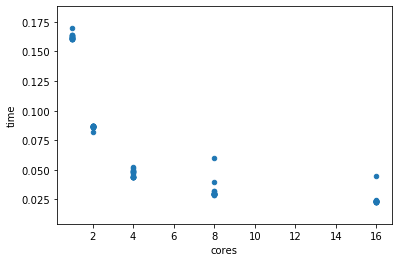

In [4]:
%matplotlib inline
df.plot(x='cores', y='time', kind='scatter')

### Speedup Chart

Use your data to make a speeedup chart.

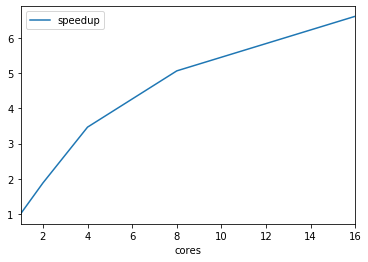

In [5]:
means = df.groupby('cores').mean()
means['speedup'] = means.loc[1].time/means['time']
means.plot(y='speedup', kind='line')

### Parallel Efficiency Chart

Same with a parallel efficiency chart.

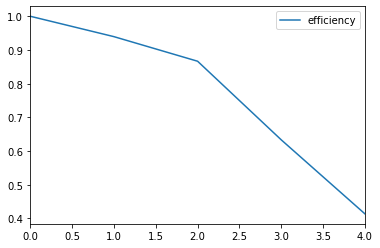

In [6]:
means.reset_index(inplace=True)
means['efficiency'] = means.loc[0].time/means['time']/means['cores']
means.plot(y='efficiency', kind='line')

### Estimate the Amdahl's Number

In [7]:
means['anumber']=means.cores/(means.cores-1)*(1-1/means.speedup)
means

,cores,time,speedup,efficiency,anumber
0,1,0.162214,1.000000,1.000000,NaN
1,2,0.086330,1.878999,0.939500,0.935604
2,4,0.046800,3.466115,0.866529,0.948657
3,8,0.032023,5.065609,0.633201,0.917246
4,16,0.024513,6.617552,0.413597,0.905479


### Discussion

* Why did scaling stop after 4 cores?
  * My laptop has 4 cores and 8 threads, what does this mean?
* Why is the Amdahl number so low?